# Multiple ancilla qubit simulation for time independent TFIM model

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin:
  [Single-ancilla ground state preparation via Lindbladians](https://arxiv.org/abs/2308.15676)

- Zhiyan Ding and Xiantao Li and Lin Lin:
  [Simulating Open Quantum Systems Using Hamiltonian Simulations](https://arxiv.org/abs/2311.15533)

## TFIM damping model, time independent Hamiltonian

In [1]:
import matplotlib.pyplot as plt
import qsimulations as qs
import numpy as np
from qutip import *
import seaborn as sns

# Activate Seaborn's default styling
sns.set()
sns.set_palette("coolwarm") 

In [2]:
g_values = [0.0, 0.5, 1, 5]

exact_traces = []
first_order_traces = []
second_order_traces = []

index = 0

In [3]:
taylor_aprox_order = (
    8  # Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)
)

g = 1  # Couppling coefficient
gamma = 1  # Damping parameter

mu = 0.1

systemSize = 2  # System Hamiltonian
nrAncillas = 2  # Ancilla size
J = systemSize  # Nr of jump operators is equal to the number of lattice elements
systemSize_dim = np.power(2, systemSize)  # Hamiltonian system size


T = 5  # Final time
dt = 0.005  # Time step
time_vec = np.arange(0, T, dt)  # Time vector to simulate on


def H_operator(t=0):
    H = np.zeros((systemSize_dim, systemSize_dim))
    if systemSize > 1:
        for i in np.arange(1, systemSize, 1):
            H = H - qs.Pauli_array(qs.Z, i, systemSize) @ qs.Pauli_array(
                qs.Z, i + 1, systemSize
            )
        H = H - qs.Pauli_array(qs.Z, systemSize, systemSize) @ qs.Pauli_array(
            qs.Z, 1, systemSize
        )
    for i in np.arange(1, systemSize + 1, 1):
        H = H - g_values[index] * qs.Pauli_array(qs.X, i, systemSize)
    for i in np.arange(1, systemSize + 1, 1):
        H = H + mu * qs.Pauli_array(qs.Z, i, systemSize)
    return Qobj(H)


print(H_operator())


def V_damping(i, t=0):
    if i == 0:
        sum = 0
        for j in np.arange(1, J + 1, 1):
            sum = sum + V_damping(j).full().conj().T @ V_damping(j).full()
        return Qobj(-1j * H_operator().full() - 0.5 * sum)

    if i >= 1 and i <= systemSize_dim:
        return Qobj(
            0.5
            * np.sqrt(gamma)
            * (
                qs.Pauli_array(qs.X, i, systemSize)
                + 1j * qs.Pauli_array(qs.Y, i, systemSize)
            )
        )
    return 0


def H_operator_derivative(t):
    return Qobj(0)


def V_operator_derivative(i, t):
    return Qobj(0)


QSystem = qs.qsimulations(systemSize, systemSize, nrAncillas)
QSystem.H_op = H_operator
QSystem.H_op_derivative = H_operator_derivative
QSystem.V_op = V_damping
QSystem.V_op_derivative = V_operator_derivative
QSystem._update_module_varibles()
QSystem._prep_energy_states()


starting_state = QSystem.rho_highest_en
mesurement_op = QSystem.rho_ground

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.8  0.   0.   0. ]
 [ 0.   2.   0.   0. ]
 [ 0.   0.   2.   0. ]
 [ 0.   0.   0.  -2.2]]
Eigenvalues:  [-2.2+0.j -1.8+0.j  2. +0.j  2. +0.j] 


Eigenvectors:  [[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]] 




### Extra math
Simulating extra jump operator free TFIM time independent model and evaluating results both from Qutip and numerical Taylor approximation.

In [4]:
import scipy.linalg as la
import scipy, numpy, math

# All ground state energy vectors:
eigenValues, eigenVectors = la.eig(H_operator(0).full())
idx = eigenValues.argsort()
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[idx]

print(eigenValues)
print(eigenVectors)
print("Calculated: ", np.array(eigenVectors[0]).conj().T  @ np.array(eigenVectors[0]))


print(np.einsum('i,j->ij', eigenVectors[0], eigenVectors[0]))

print(starting_state)
# Time evolution of time independent hamiltonian, without damping operators

def single_taylor(matrix, order, time_step):
    sum_tmp = np.zeros(np.power(2,systemSize))  
    for i in np.arange(0, order, 1):
        # tmp = np.power(matrix, i)
        tmp = np.linalg.matrix_power(matrix, i)
        tmp = tmp / math.factorial(i)
        tmp = np.power(-1j*time_step, i)*tmp
        sum_tmp = sum_tmp + tmp
    return sum_tmp

results_Taylor = []
time_evolution = starting_state.full()

N = (int)(T/dt)
matrix = H_operator(0).full()
order = 5

for n in np.arange(0, N, 1):
    time_evolution = single_taylor(matrix, order, dt) @ time_evolution @ np.conj(single_taylor(matrix, order, dt)).T
    results_Taylor.append(time_evolution)


result_taylor_overlap = []
for i in results_Taylor:
        result_taylor_overlap.append(np.trace(i @ mesurement_op.full()))



[-2.2+0.j -1.8+0.j  2. +0.j  2. +0.j]
[[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]
Calculated:  (1+0j)
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


### Exact simulation


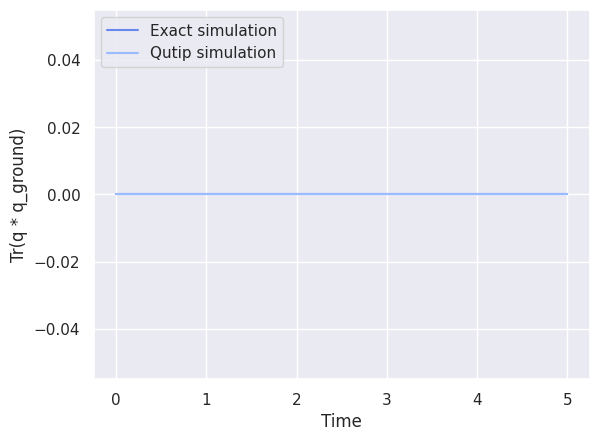

In [5]:
import matplotlib.pyplot as plt
from qutip import mesolve
import numpy as np

rho = starting_state
exact_trace = []
for t in time_vec:
    sum = Qobj(np.zeros((QSystem._systemSizeDim, QSystem._systemSizeDim)))
    for j in np.arange(1, J + 1, 1):
        sum = (
            sum
            + QSystem.V_op(j) @ rho @ QSystem.V_op(j).conj().trans()
            - 0.5
            * (
                QSystem.V_op(j).conj().trans() @ QSystem.V_op(j) @ rho
                + rho @ QSystem.V_op(j).conj().trans() @ QSystem.V_op(j)
            )
        )
    delta_rho = -1j * (QSystem.H_op() @ rho - rho @ QSystem.H_op()) + sum
    rho = rho + dt * delta_rho
    exact_trace.append((rho @ mesurement_op).tr())

V1 = V_damping(1)
V2 = V_damping(2)
results2 = mesolve(
    QSystem.H_op(), Qobj(starting_state), time_vec, [V1, V2], [mesurement_op]
)

# results2 = mesolve(
#     QSystem.H_op(), Qobj(starting_state), time_vec, c_ops=None, e_ops=[mesurement_op]
# )


# Add Taylor simulation for only the Hamiltonian system

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, exact_trace, label="Exact simulation")
plt.plot(time_vec, results2.expect[0], label="Qutip simulation")
# plt.plot(time_vec, result_taylor_overlap, label="Taylor aprox simulation")
plt.legend(loc="upper left")
plt.savefig("tfim_time_indep/exact_sim_gamma_"+str(g_values[index])+".png")



In [6]:
exact_traces.append(exact_trace)

In [7]:

# plt.figure()
# plt.xlabel("Time")
# plt.ylabel("Tr(q * q_ground)")
# # plt.plot(time_vec, exact_trace, label="Exact simulation")
# plt.plot(time_vec, results2.expect[0], label="Qutip simulation")
# plt.plot(time_vec, results_Taylor, label="Taylor aprox simulation")
# plt.legend(loc="upper left")

### First order approximation

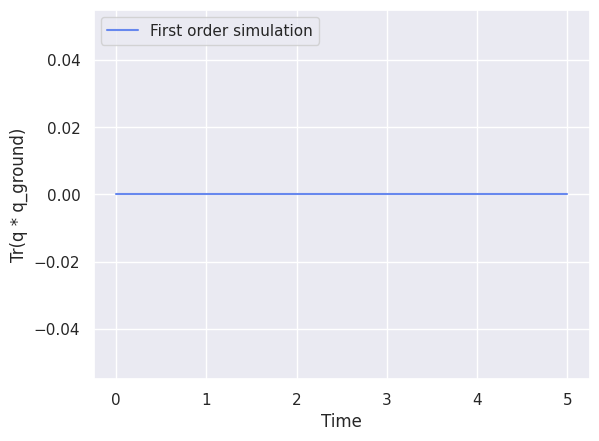

In [8]:
import math
import numpy as np

ancilla = 2  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = starting_state
first_order_trace = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_first_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    first_order_trace.append((rho @ mesurement_op).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, first_order_trace, label="First order simulation")
plt.legend(loc="upper left")
plt.savefig("tfim_time_indep/first_order_gamma_"+str(g_values[index])+".png")

In [9]:
first_order_traces.append(first_order_trace)

### Second order approximation

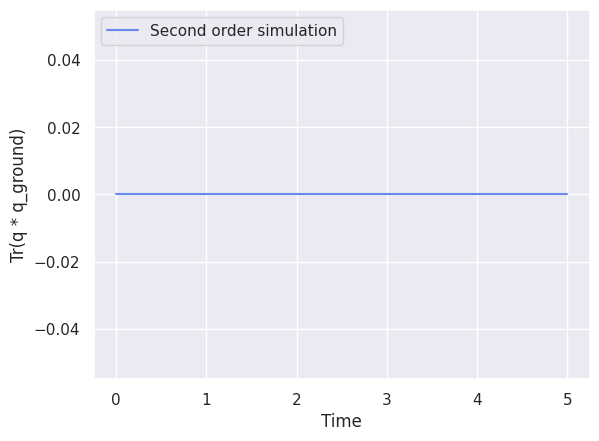

In [10]:
import math
import numpy as np

ancilla = 5  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = starting_state
second_order_trace = []
for t in time_vec:
    # print(t)
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_second_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    second_order_trace.append((rho @ mesurement_op).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
plt.plot(time_vec, second_order_trace, label="Second order simulation")
plt.legend(loc="upper left")
plt.savefig("tfim_time_indep/second_order_gamma_"+str(g_values[index])+".png")

In [11]:
second_order_traces.append(second_order_trace)

10


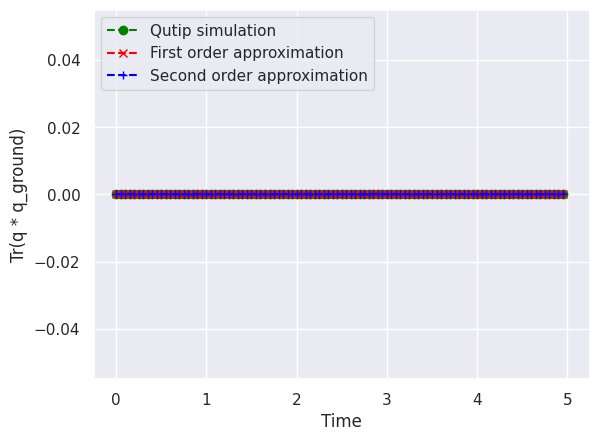

In [12]:
import matplotlib.pyplot as plt

total_nr_of_points = 100
plot_density = (int)(np.size(time_vec) / total_nr_of_points)
print(plot_density)

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")
# plt.plot(time_vec, exact_trace, label="Exact simulation")
plt.plot(
    time_vec,
    exact_trace,
    label="Qutip simulation",
    color="green",
    marker="o",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    first_order_trace,
    label="First order approximation",
    color="red",
    marker="x",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    second_order_trace,
    label="Second order approximation",
    color="blue",
    marker="+",
    linestyle="dashed",
    markevery=plot_density,
)
plt.legend(loc="upper left")
plt.savefig("tfim_time_indep/combined_gamma_"+str(g_values[index])+".png")


0
1


IndexError: list index out of range

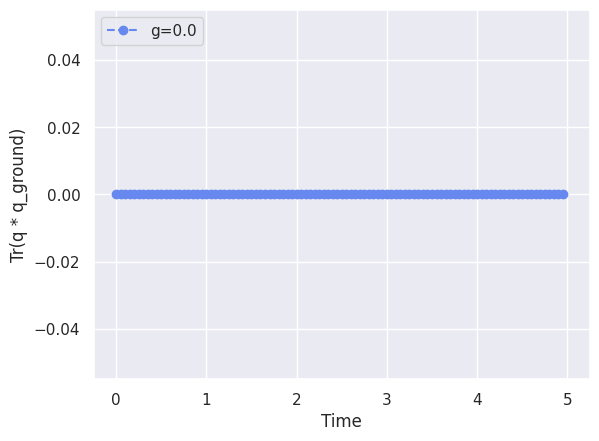

In [13]:
plt.figure()

for i in range(len(g_values)):
    print(i)
    plt.xlabel("Time")
    plt.ylabel("Tr(q * q_ground)")

    # plt.plot(time_vec, exact_trace, label="Exact simulation")
    plt.plot(
        time_vec,
        exact_traces[i],
        label="g="+str(g_values[i]),
        # color="green",
        marker="o",
        linestyle="dashed",
        markevery=plot_density,
    )
    plt.legend(loc="upper left")
    plt.savefig("tfim_time_indep/exact_simulation.png")

    # plt.plot(
    #     time_vec,
    #     first_order_traces[i],
    #     label="g="+str(g_values[i]),
    #     # color="red",
    #     marker="o",
    #     linestyle="dashed",
    #     markevery=plot_density,
    # )
    # plt.legend(loc="upper left")
    # plt.savefig("tfim_time_indep/first_order.png")

    # plt.plot(
    #     time_vec,
    #     second_order_traces[i],
    #     label="g="+str(g_values[i]),
    #     marker="o",
    #     linestyle="dashed",
    #     markevery=plot_density,
    # )
    # plt.legend(loc="upper left")
    # plt.savefig("tfim_time_indep/second_order.png")
